# 机器学习模型 CatBoost 原理、代码及应用

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve,validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,KFold
from catboost import Pool,metrics,cv,MetricVisualizer
from catboost.utils import create_cd,get_roc_curve,select_threshold,get_fpr_curve,get_fnr_curve
from catboost import CatBoostClassifier,CatBoostRegressor
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
import shap

In [3]:
def reduce_mem_usage(data):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = data.memory_usage().sum() 
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')
    end_mem = data.memory_usage().sum() 
    return data 

In [8]:
# train_data = reduce_mem_usage(pd.read_csv(path + 'data/train.csv',encoding='utf-8'))

In [30]:
test_data = reduce_mem_usage(pd.read_csv( './data/test.csv',encoding='utf-8'))
data = pd.read_csv( './feature/feature_40.csv')

In [8]:
del data['Unnamed: 0']
del data['pid_id']

In [37]:
def replace_nan(x):
    if x != -1:
        return x
    else:
        return np.nan

In [38]:
replace_cols = ['first_year', 'last_year', 'session_count', 'first_time', 'last_time', 'active_days',
       'dif_days_total', 'dif_days_avg', 'day_sessions_avg', '2023_session_count', '2023_first_time', '2023_last_time',
       '2023_active_days', '2023_recency', '2023_dif_days_total', '2023_dif_days_avg', '2023_day_sessions_avg',]
for col in replace_cols:
    data[col] = data[col].apply(replace_nan)

In [48]:
time_col = [ 'first_time', 'last_time','2023_first_time', '2023_last_time']
for col in time_col: 
    data[col] =  pd.to_datetime(data[col],format='%Y-%m-%d', errors='coerce')

In [11]:
del data['year_-1.0_count']
del data['month_-1.0_count']
del data['dayofweek_-1.0_count']

In [53]:
def is_year_2023(x):
    if x==0:
        return 1
    else:
        return 0

In [54]:
data['is_2023_last_year'] = data['last_year'].apply(is_year_2023)

In [55]:
data['is_2023_first_year'] = data['first_year'].apply(is_year_2023)

In [158]:
data['is_2023_last_year'] = data['is_2023_last_year'].astype(str)
data['is_2023_first_year'] = data['is_2023_first_year'].astype(str)

In [12]:
del data['pid_id']
del data['first_time']
del data['last_time']
del data['2023_first_time']
del data['2023_last_time']

In [10]:
data

,label,brand,model,province,city,first_year,last_year,session_count,active_days,dif_days_total,...,dayofweek_6.0_count,is_2023_last_year,is_2023_first_year,value_mean,2023_session_rate,2023_active_rate,2023_difdays_reduce,2023_day_sessions_rate,2023_day_sessions_pro,2023_difdays_reduce_rate
0,0.0,0,0,0,0,1.0,0.0,30.0,11.0,249.0,...,13.0,1,0,89.90,0.70,0.55,10.47,1.14,0.68,0.46
1,0.0,1,1,1,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2,2,2,2,1.0,0.0,61.0,20.0,337.0,...,6.0,1,0,83.06,0.61,0.45,0.51,1.21,1.23,0.03
3,1.0,3,3,3,3,0.0,0.0,2.0,1.0,0.0,...,0.0,1,1,0.00,1.00,1.00,0.00,1.00,0.00,NaN
4,0.0,3,4,4,4,1.0,0.0,50.0,11.0,349.0,...,8.0,1,0,54.50,0.80,0.73,10.85,1.07,0.44,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,NaN,340,1996,5,5,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699996,NaN,3,34,5,56,1.0,1.0,1.0,1.0,0.0,...,0.0,0,0,92.00,NaN,NaN,NaN,NaN,NaN,NaN
699997,NaN,2,254,30,300,1.0,1.0,1.0,1.0,0.0,...,0.0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
699998,NaN,3,121,29,98,1.0,0.0,39.0,15.0,254.0,...,12.0,1,0,89.00,0.62,0.40,5.27,1.29,1.43,0.31


In [11]:
data.columns

Index(['label', 'brand', 'model', 'province', 'city', 'first_year',
       'last_year', 'session_count', 'active_days', 'dif_days_total',
       'dif_days_avg', 'day_sessions_avg', '2023_session_count',
       '2023_active_days', '2023_recency', '2023_dif_days_total',
       '2023_dif_days_avg', '2023_day_sessions_avg', 'year_2009.0_count',
       'year_2010.0_count', 'year_2015.0_count', 'year_2017.0_count',
       'year_2018.0_count', 'year_2019.0_count', 'year_2020.0_count',
       'year_2021.0_count', 'year_2022.0_count', 'year_2023.0_count',
       'month_1.0_count', 'month_2.0_count', 'month_3.0_count',
       'month_4.0_count', 'month_5.0_count', 'month_6.0_count',
       'month_7.0_count', 'month_8.0_count', 'month_9.0_count',
       'month_10.0_count', 'month_11.0_count', 'month_12.0_count',
       'dayofweek_0.0_count', 'dayofweek_1.0_count', 'dayofweek_2.0_count',
       'dayofweek_3.0_count', 'dayofweek_4.0_count', 'dayofweek_5.0_count',
       'dayofweek_6.0_count', 'is_20

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   label                     209470 non-null  float64
 1   brand                     700000 non-null  int64  
 2   model                     700000 non-null  int64  
 3   province                  700000 non-null  int64  
 4   city                      700000 non-null  int64  
 5   first_year                497363 non-null  float64
 6   last_year                 497367 non-null  float64
 7   session_count             497368 non-null  float64
 8   active_days               497368 non-null  float64
 9   dif_days_total            497368 non-null  float64
 10  dif_days_avg              497368 non-null  float64
 11  day_sessions_avg          497368 non-null  float64
 12  2023_session_count        326223 non-null  float64
 13  2023_active_days          326223 non-null  f

梯度提升概述
- **Bagging**：该技术使用随机数据子集并行构建不同的模型，并聚合所有预测变量的预测结果。
- **Boosting**：这种技术是可迭代的、顺序进行的和自适应的，因为每个预测器都是针对上一个模型的错误进行修正。
- **Stacking**：这是一种元学习技术，涉及结合来自多种机器学习算法的预测，例如 bagging 和 boosting。

CatBoost 
- 是一种基于 **对称决策树（oblivious trees）**为基学习器实现的参数较少、支持类别型变量和高准确性的GBDT框架。   

- 解决了**梯度偏差（Gradient Bias）**以及**预测偏移（Prediction shift）**的问题，从而减少过拟合的发生，进而提高算法的准确性和泛化能力。   

- 学习算法基于 GPU 实现，打分算法基于 CPU 实现。

## CatBoost 的主要特点

 ### 1.对称树

#### FloatFeature
- 模型没有类别型特征时，在可视化的树中只有 "FloatFeature" 节点。"FloatFeature" 拆分对应的节点包含特征索引和边界值，用于拆分对象。

In [20]:
float_features = ['session_count', 'active_days','dif_days_total', 'dif_days_avg', 'day_sessions_avg',
       '2023_session_count', '2023_active_days', '2023_recency', '2023_dif_days_total','2023_dif_days_avg', '2023_day_sessions_avg']

In [63]:
float_data = data[float_cols]

In [64]:
float_data = float_data.fillna(0)

In [65]:
float_data

,session_count,active_days,dif_days_total,dif_days_avg,day_sessions_avg,2023_session_count,2023_active_days,2023_recency,2023_dif_days_total,2023_dif_days_avg,2023_day_sessions_avg
0,30.0,11.0,249.0,22.640625,4.800781,21.0,6.0,129.0,73.0,12.171875,5.480469
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,61.0,20.0,337.0,16.843750,5.820312,37.0,9.0,46.0,147.0,16.328125,7.050781
3,2.0,1.0,0.0,0.000000,2.000000,2.0,1.0,56.0,0.0,0.000000,2.000000
4,50.0,11.0,349.0,31.734375,6.160156,40.0,8.0,34.0,167.0,20.875000,6.601562
...,...,...,...,...,...,...,...,...,...,...,...
699995,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
699996,1.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
699997,1.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
699998,39.0,15.0,254.0,16.937500,4.898438,24.0,6.0,133.0,70.0,11.671875,6.328125


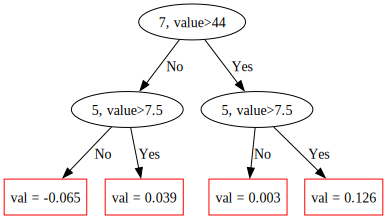

In [130]:
x = float_data[:209470]
y = train_data['label']
pool = catboost.Pool(data=x,label=y)
model = CatBoostRegressor(depth=2,verbose=False,iterations=10).fit(x,y)
model.plot_tree(tree_idx=0)

#### OneHotFeature 
- 模型只有类别型特征时，在可视化的树中只有 "OneHotFeature" 节点

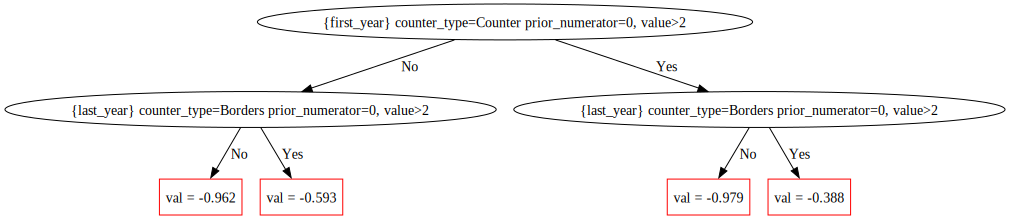

In [133]:
cat_features = [ 'brand', 'model', 'province', 'city','first_year','last_year']
cat_data = data[cat_features].astype('str')
x = cat_data[:209470] 
y = train_data['label']
pool = Pool(x,y,cat_features=cat_features,feature_names=list(x.columns))
model = CatBoostClassifier(max_depth=2,verbose=False,
                           max_ctr_complexity=1,random_seed=42,iterations=2).fit(pool)
model.plot_tree(tree_idx=0,pool=pool)

#### OnlineCtr

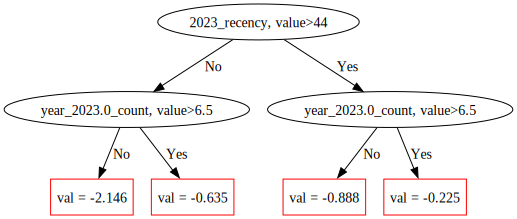

In [134]:
cat_features = [ 'brand', 'model', 'province', 'city','first_year','last_year']
x = data[:209470] 
y = train_data['label']
pool = Pool(x,y,cat_features=cat_features,feature_names=list(x.columns))
model = CatBoostClassifier(max_depth=2,verbose=False,
                           max_ctr_complexity=1,random_seed=42,iterations=2).fit(pool)
model.plot_tree(tree_idx=0,pool=pool)

### 2.Ordered Boosting
- CatBoost 使用排序提升的概念，这是一种置换驱动的方法，在数据子集上训练模型，同时在另一个子集上计算残差，从而防止目标泄漏和过度拟合。

### 3.鲁棒性
- CatBoost 减少了对大量超参数调整的需求，并降低了过度拟合的机会，这也导致了更通用的模型

#### 4. 原生特征支持,易于使用
- CatBoost 支持数字、分类或文本的各种特征，节省了预处理的时间和精力。可以从命令行使用 CatBoost，使用 Python 和 R 的用户友好 API。

## CatBoost 的基本使用

### baseline模型

In [147]:
# 超出分布范围的数字填充缺失值
# data = data.fillna(-99)
x = data[:209470]
y = train_data['label']
test = data[209470:]
cat_features = [ 'brand', 'model', 'province', 'city','first_year','last_year']

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.25,random_state=42)
model = CatBoostClassifier(custom_loss=[metrics.Accuracy()],random_seed=42,logging_level='Silent')
model.fit(x_train,y_train,cat_features=cat_features,eval_set=(x_val,y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 特征变量统计

#### FloatFeature

In [137]:
float_features = ['session_count', 'active_days','dif_days_total', 'dif_days_avg', 'day_sessions_avg',
       '2023_session_count', '2023_active_days', '2023_recency', '2023_dif_days_total','2023_dif_days_avg', '2023_day_sessions_avg']
res = model.calc_feature_statistics(x_train,y_train,float_features,plot=True)

#### OneHotFeature 

In [149]:
# res = model.calc_feature_statistics(x_train,y_train,cat_features,plot=True)

### 模型交叉验证

In [151]:
cv_params = model.get_params()
cv_params.update({'loss_function':metrics.Logloss()})
cv_data = cv(Pool(x,y,cat_features=cat_features),cv_params,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [153]:
print('best validation accuracy score:{:.2f}±{:.2f} on step{}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])))
print('precise validation accuracy score:{}'.format(np.max(cv_data['test-Accuracy-mean'])))

best validation accuracy score:0.88±0.00 on step966
precise validation accuracy score:0.8790566607413816


### 模型应用

In [154]:
predictions = model.predict(test)
predictions_probs = model.predict_proba(test)

print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 0 0 0 0 0 0]
[[0.96593141 0.03406859]
 [0.73424569 0.26575431]
 [0.99336773 0.00663227]
 [0.57450805 0.42549195]
 [0.99545049 0.00454951]
 [0.99289297 0.00710703]
 [0.98199315 0.01800685]
 [0.95429808 0.04570192]
 [0.99444773 0.00555227]
 [0.98429281 0.01570719]]


## CatBoost 的应用实例

In [19]:
cat_features = [ 'brand', 'model', 'province', 'city','first_year','last_year', 'is_2023_last_year', 'is_2023_first_year']
data[cat_features] = data[cat_features].astype('str')
# float_features = list(data.drop(columns=cat_features,axis=1).columns)

x = data.drop('label',axis=1)[:209470]
y = data['label'][:209470]
test = data.drop('label',axis=1)[209470:]

In [42]:
train_data = x.merge(y,how='left')

In [20]:
x

,brand,model,province,city,first_year,last_year,session_count,active_days,dif_days_total,dif_days_avg,...,dayofweek_6.0_count,is_2023_last_year,is_2023_first_year,value_mean,2023_session_rate,2023_active_rate,2023_difdays_reduce,2023_day_sessions_rate,2023_day_sessions_pro,2023_difdays_reduce_rate
0,0,0,0,0,1.0,0.0,30.0,11.0,249.0,22.64,...,13.0,1,0,89.90,0.70,0.55,10.47,1.14,0.68,0.46
1,1,1,1,1,nan,nan,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,2,1.0,0.0,61.0,20.0,337.0,16.84,...,6.0,1,0,83.06,0.61,0.45,0.51,1.21,1.23,0.03
3,3,3,3,3,0.0,0.0,2.0,1.0,0.0,0.00,...,0.0,1,1,0.00,1.00,1.00,0.00,1.00,0.00,NaN
4,3,4,4,4,1.0,0.0,50.0,11.0,349.0,31.73,...,8.0,1,0,54.50,0.80,0.73,10.85,1.07,0.44,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209465,7,285,7,250,1.0,1.0,4.0,1.0,0.0,0.00,...,0.0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
209466,3,28,15,223,0.0,0.0,2.0,1.0,0.0,0.00,...,0.0,1,1,0.00,1.00,1.00,0.00,1.00,0.00,NaN
209467,4,122,24,57,1.0,0.0,6.0,2.0,214.0,107.00,...,0.0,1,0,62.56,0.67,0.50,107.00,1.20,0.67,1.00
209468,3,233,22,148,4.0,4.0,54.0,2.0,25.0,12.50,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
test

,brand,model,province,city,first_year,last_year,session_count,active_days,dif_days_total,dif_days_avg,...,dayofweek_6.0_count,is_2023_last_year,is_2023_first_year,value_mean,2023_session_rate,2023_active_rate,2023_difdays_reduce,2023_day_sessions_rate,2023_day_sessions_pro,2023_difdays_reduce_rate
209470,2,103,24,136,1.0,1.0,2.0,1.0,0.0,0.00,...,0.0,0,0,93.00,NaN,NaN,NaN,NaN,NaN,NaN
209471,0,283,20,227,1.0,0.0,48.0,19.0,221.0,11.63,...,3.0,1,0,88.25,0.58,0.21,1.63,1.52,2.97,0.14
209472,11,828,4,17,nan,nan,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209473,3,223,21,84,1.0,0.0,10.0,3.0,253.0,84.30,...,0.0,1,0,57.60,0.40,0.33,84.30,0.95,-0.20,1.00
209474,0,385,18,102,nan,nan,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,340,1996,5,5,nan,nan,NaN,NaN,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699996,3,34,5,56,1.0,1.0,1.0,1.0,0.0,0.00,...,0.0,0,0,92.00,NaN,NaN,NaN,NaN,NaN,NaN
699997,2,254,30,300,1.0,1.0,1.0,1.0,0.0,0.00,...,0.0,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
699998,3,121,29,98,1.0,0.0,39.0,15.0,254.0,16.94,...,12.0,1,0,89.00,0.62,0.40,5.27,1.29,1.43,0.31


In [22]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.25,random_state=42)

In [23]:
pool = Pool(x,y,cat_features=cat_features,feature_names=list(x.columns))

### 检查数据集中标签平衡性

In [210]:
print('labels:{}'.format(set(y)))
print('zero count = {}, one count = {}'.format(len(y)-sum(y),sum(y)))

labels:{0, 1}
zero count = 179489, one count = 29981


### 保存数据

In [53]:
dataset_dir = './user_recommend'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
train_data.to_csv(
    os.path.join(dataset_dir,'train_feature3.csv'),
    index=False,sep=',',header=True)
test.to_csv(
    os.path.join(dataset_dir,'test_feature3.csv'),
    index=False,sep=',',header=True)

### 创建特征字典

In [192]:
feature_names = {}
feature_list = list(x.columns)
for ind,val in enumerate(feature_list):
    feature_names[ind +1] = val

create_cd(
    label=0,
    cat_features = list(range(1,7)),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir,'train.cd'))  

In [185]:
# !cat user_recommend/train.cd

### 创建pool类

In [ ]:
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train_feature3.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True)

### 模型比较

In [166]:
model_1 = CatBoostClassifier(iterations=1000,
                             learning_rate=0.5,
                             max_depth=6,
                             random_seed=42,
                             train_dir='learning_rate_0.5')

model_2 = CatBoostClassifier(iterations=1000,
                             learning_rate=0.1,
                             max_depth=6,
                             random_seed=42,
                             train_dir='learning_rate_0.1')

model_3 = CatBoostClassifier(iterations=1000,
                             learning_rate=0.05,
                             max_depth=6,
                             random_seed=42,
                             train_dir='learning_rate_0.05')
model_1.fit(x_train,y_train,
            eval_set=(x_val,y_val),
            cat_features=cat_features,
            verbose=False)

model_2.fit(x_train,y_train,
            eval_set=(x_val,y_val),
            cat_features=cat_features,
            verbose=False)

model_3.fit(x_train,y_train,
            eval_set=(x_val,y_val),
            cat_features=cat_features,
            verbose=False)

In [168]:
MetricVisualizer(['learning_rate_0.5','learning_rate_0.1','learning_rate_0.05']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 交叉验证

In [213]:
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1200
params['learning_rate'] = 0.1
params['random_seed'] = 88
params['custom_loss'] = 'AUC'

cv_data = cv(
            params=params,
            pool = Pool(x,y,cat_features),
            fold_count=3,
            shuffle=True,
            partition_random_seed=0,
            stratified=False,
            verbose=False,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.252584911
bestIteration = 947

Training on fold [1/3]

bestTest = 0.2545493051
bestIteration = 766

Training on fold [2/3]

bestTest = 0.2516287367
bestIteration = 854



In [216]:
cv_data

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.578316,0.001651,0.578288,0.001451,0.842886,0.015941
1,1,0.495124,0.002456,0.495038,0.002409,0.863687,0.004853
2,2,0.439856,0.004092,0.439738,0.003595,0.870283,0.002404
3,3,0.398999,0.005835,0.398865,0.005699,0.873117,0.003759
4,4,0.367910,0.004392,0.367792,0.004456,0.875677,0.004284
...,...,...,...,...,...,...,...
1195,1195,0.253193,0.001576,0.212194,0.000962,0.905298,0.000614
1196,1196,0.253193,0.001574,0.212177,0.000971,0.905298,0.000611
1197,1197,0.253189,0.001572,0.212146,0.000976,0.905300,0.000609
1198,1198,0.253192,0.001576,0.212110,0.000967,0.905298,0.000610


In [217]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('precise validation Logloss score,not stratified:{:.4f}±{:.4f} on step{}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter))

precise validation Logloss score,not stratified:0.2530±0.0015 on step861


In [218]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])

print('precise validation AUC score,not stratified:{:.4f}±{:.4f} on step{}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter))

precise validation AUC score,not stratified:0.9054±0.0006 on step905


### 过拟合检验：设置早停

In [180]:
model1_with_early_stop = CatBoostClassifier(iterations=2000,
                             learning_rate=0.1,
                             loss_function='Logloss',
                             custom_loss='AUC',
                             eval_metric='AUC',
                             random_seed=42,
                             early_stopping_rounds=30)
model1_with_early_stop.fit(x_train,y_train,
            eval_set=(x_val,y_val),
            cat_features=cat_features,
            verbose=False,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [181]:
print(model1_with_early_stop.tree_count_)

439


In [1]:
model2_with_early_stop = CatBoostClassifier(iterations=5000,
                             learning_rate=0.01,
                             loss_function='Logloss',
                             custom_loss='AUC',
                             eval_metric='AUC',
                             random_seed=42,
                             early_stopping_rounds=30)

model2_with_early_stop.fit(x_train,y_train,
            eval_set=(x_val,y_val),
            cat_features=cat_features,
            verbose=False,
            plot=True)

In [179]:
print(model2_with_early_stop.tree_count_)

3463


### 选择概率决策边界

#### 绘制ROC曲线

In [24]:
model = CatBoostClassifier(iterations=10000,
                             learning_rate=0.01,
                             loss_function='Logloss',
                             custom_loss='AUC',
                             eval_metric='AUC',
                             random_seed=42,
                             early_stopping_rounds=50)
model.fit(x_train,y_train,
        eval_set=(x_val,y_val),
        cat_features=cat_features,
        verbose=False)

eval_pool = Pool(x_val,y_val,cat_features=cat_features)
curve = get_roc_curve(model,eval_pool)
(fpr,tpr,thresholds ) = curve 
roc_auc = auc(fpr,tpr)

In [35]:
print(roc_auc)

0.9050257963849956


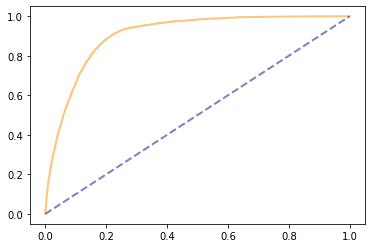

In [25]:
lw = 2
plt.plot(fpr,tpr,color='darkorange',
        lw=lw,label='ROC curve (area = %0.2f)' % roc_auc,alpha=0.5)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--',alpha=0.5)

#### 绘制 FPR FNR 曲线

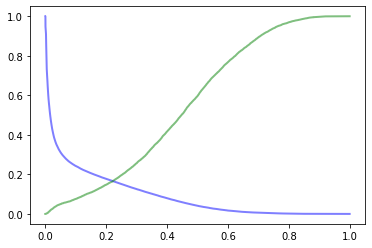

In [26]:
(thresholds,fpr) = get_fpr_curve(curve=curve)
(thresholds,fnr) = get_fnr_curve(curve=curve)
lw = 2
plt.plot(thresholds,fpr,color='blue',lw=lw,label='FPR',alpha=0.5)
plt.plot(thresholds,fnr,color='green',lw=lw,label='FNR',alpha=0.5)

In [27]:
# 返回指定的FNR 或 FPR所需的概率边界

print(select_threshold(model=model,data=eval_pool,FNR=0.01))
print(select_threshold(model=model,data=eval_pool,FPR=0.01))

0.01073248031004543
0.6534643038030938


### 模型预测
- predict
    - prediction_type 参数，支持的预测类型
        - Probability
        - Class
        - RawFormulaVal
        - Exponent
        - LogProbability
- predict_proba
- staged_predict
- staged_predict_prob

In [28]:
prediction = model.predict(test)

In [298]:
prediction.shape

(490530,)

In [31]:
result_catb_1 = pd.DataFrame()
result_catb_1['pid'] = test_data.pid
result_catb_1['label'] = prediction

In [32]:
result_catb_1.to_csv(path +'result/result_catb_30.csv',index=False)
result_catb_1['label'].value_counts()/len(result_catb_1)

0.0    0.916664
1.0    0.083336
Name: label, dtype: float64

In [309]:
prediction_proba = model.predict(test,prediction_type='RawFormulaVal')

In [310]:
sigmoid = lambda x:1/(1+ np.exp(-x))
prediction_proba = sigmoid(prediction_proba)

In [318]:
prediction_proba

array([0.03548199, 0.25062519, 0.00726759, ..., 0.01952296, 0.53361962,
       0.2602124 ])

In [319]:
result_catb_2 = pd.DataFrame()
result_catb_2['pid'] = test_data.pid
result_catb_2['label'] = prediction_proba

In [286]:
fpr = select_threshold(model=model,data=eval_pool,FPR=0.01)
fpr

0.6648384996766187

In [320]:
result_catb_2['label'] = result_catb_2['label'].apply(lambda x:1 if x>fpr else 0)
result_catb_2.to_csv(path + 'result/result_catb_31.csv',index=False)
result_catb_2['label'].value_counts()/len(result_catb_2)

0    0.973514
1    0.026486
Name: label, dtype: float64

In [ ]:
prediction_2 = model2_with_early_stop.predict(test)

In [ ]:
result_catb_3 = pd.DataFrame()
result_catb_3['pid'] = test_data.pid
result_catb_3['label'] = prediction_2

In [196]:
raw_pred = model.predict(data=x_val,prediction_type='RawFormulaVal')
print(raw_pred)

[-3.34176653 -5.5814123  -6.2756005  ... -0.61956112 -5.65893738
 -5.68109728]


In [197]:
# 通过sigmoid 函数将上面结果转换为概率

sigmoid = lambda x:1/(1+ np.exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities)

[0.03416582 0.0037531  0.00187813 ... 0.34988128 0.00347411 0.00339823]


staged_predict & staged_predict_prob
- 是阶段预测，仅考虑仅考虑 trees 在range[0; i) 内的计算结果值。
- 这个范围是通过参数eval_period控制的：要在应用模型或计算指标时减少要使用的树的数量，将树索引的范围设置为[ntree_start; ntree_end)并将要使用的树的步长设置为eval_period。

In [199]:
predictions_gen = model.staged_predict_proba(
    data = x_val,
    ntree_start=0,
    ntree_end=5,
    eval_period=1)
try:
    for iteration,predictions in enumerate(predictions_gen):
        print('Iteration' + str(iteration) + ',predictions:')
        print(predictions)
except Exception:
    pass

Iteration0,predictions:
[[0.59489211 0.40510789]
 [0.6234904  0.3765096 ]
 [0.59489211 0.40510789]
 ...
 [0.51568928 0.48431072]
 [0.6234904  0.3765096 ]
 [0.6234904  0.3765096 ]]
Iteration1,predictions:
[[0.68705577 0.31294423]
 [0.71229442 0.28770558]
 [0.68705577 0.31294423]
 ...
 [0.52774759 0.47225241]
 [0.71229442 0.28770558]
 [0.71229442 0.28770558]]
Iteration2,predictions:
[[0.75590149 0.24409851]
 [0.77738682 0.22261318]
 [0.75590149 0.24409851]
 ...
 [0.55071944 0.44928056]
 [0.77738682 0.22261318]
 [0.77738682 0.22261318]]
Iteration3,predictions:
[[0.8024322  0.1975678 ]
 [0.8207929  0.1792071 ]
 [0.8024322  0.1975678 ]
 ...
 [0.55235342 0.44764658]
 [0.8207929  0.1792071 ]
 [0.8207929  0.1792071 ]]
Iteration4,predictions:
[[0.85011216 0.14988784]
 [0.85101996 0.14898004]
 [0.85011216 0.14988784]
 ...
 [0.54993864 0.45006136]
 [0.86478844 0.13521156]
 [0.86478844 0.13521156]]


#### 在未知数据集上评估模型

In [221]:
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True)

In [ ]:
print('AUC values:')
print(np.array(metrics['AUC']))

## 特征重要性

In [33]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,2023_recency,18.949611
1,city,10.862860
2,brand,7.685538
3,model,4.572764
4,value_mean,4.442831
5,2023_session_rate,3.022207
6,2023_dif_days_total,2.744422
7,month_3.0_count,2.658916
8,last_year,2.633586
9,first_year,2.577034


In [258]:
pool = Pool(data=x,label=y,cat_features=cat_features)
shap_values = model.get_feature_importance(pool,type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [259]:
print(shap_values.shape)

(209470, 48)


In [273]:
shap.initjs()
shap.force_plot(expected_value,shap_values[3,:],x.iloc[3,:])

In [276]:
shap.initjs()
shap.force_plot(expected_value,shap_values[99,:],x.iloc[99,:])

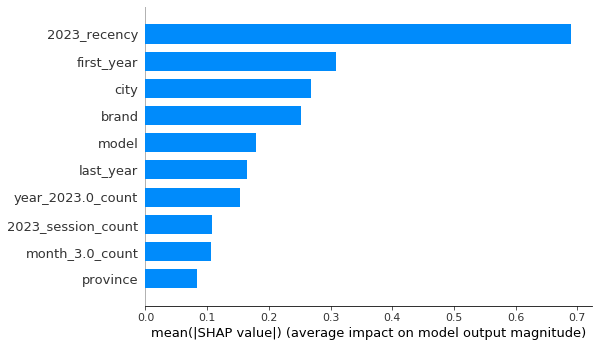

In [274]:
shap.summary_plot(shap_values,x,plot_type='bar',max_display=10) 

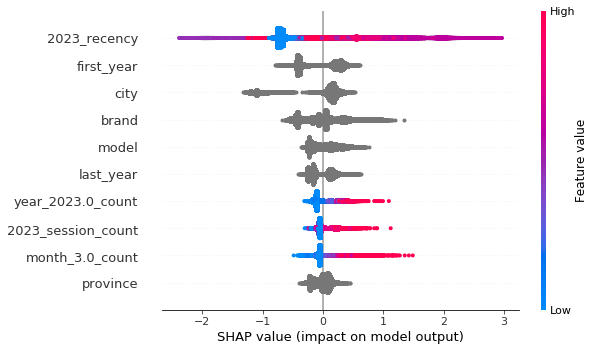

In [275]:
shap.summary_plot(shap_values,x,max_display=10) 

## 特征评估

In [199]:
learn_params = {'iterations':100,
               'learning_rate':0.5,
               'random_seed':0,
               'verbose':False,
               'loss_function':'Logloss',
               'boosting_type':'Plain'}

evaluator = CatboostEvaluation(
                'user_recommend/train_feature3.csv',
                fold_size=1000,
                fold_count=10,
                column_description='user_recommend/train.cd',
                partition_random_seed=0)

result = evaluator.eval_features(
            learn_config=learn_params,
            eval_metrics=['Logloss','AUC'],
            features_to_eval=[1,2,3,4])

In [ ]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

## 模型保存和导入

In [ ]:
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)